In [4]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pickle
from pathlib import Path
import torch
import torch.nn.functional as F
from google.protobuf import text_format
from second.utils import simplevis
from second.pytorch.train import build_network
from second.protos import pipeline_pb2
from second.utils import config_tool
from second.pytorch.builder import (box_coder_builder, input_reader_builder,
                                    lr_scheduler_builder, optimizer_builder,
                                    second_builder)
from second.data.preprocess import merge_second_batch, merge_second_batch_multigpu
from second.pytorch.train import _worker_init_fn

from second.pytorch.train import example_convert_to_torch

from second.sphere.conv import init_depth_from_feature, depth_to_3D

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [21]:
config_path = "/home/gx/GitHub/depconv/second/configs/car.fhd.config"
config = pipeline_pb2.TrainEvalPipelineConfig()
with open(config_path, "r") as f:
    proto_str = f.read()
    text_format.Merge(proto_str, config)
input_cfg = config.train_input_reader
model_cfg = config.model.second

# config_tool.change_detection_range(model_cfg, [-50, -50, 50, 50])
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# device = torch.device("cpu")

ckpt_path = "/home/gx/GitHub/depconv/second/depconv32/voxelnet-27840.tckpt"
net = build_network(model_cfg).to(device).eval()
net.load_state_dict(torch.load(ckpt_path))
target_assigner = net.target_assigner
voxel_generator = net.voxel_generator
config.train_input_reader.batch_size=1
# config.train_input_reader.batch_size


dataset = input_reader_builder.build(
    input_cfg,
    model_cfg,
    training=True,
    voxel_generator=voxel_generator,
    target_assigner=target_assigner,
    multi_gpu=False)

num_gpu=1
collate_fn= merge_second_batch
multi_gpu = False
dataloader = torch.utils.data.DataLoader(
        dataset,
        batch_size=input_cfg.batch_size * num_gpu,
        shuffle=True,
#         num_workers=input_cfg.preprocess.num_workers * num_gpu,
        num_workers=1,
        pin_memory=False,
        collate_fn=collate_fn,
        worker_init_fn=_worker_init_fn,
        drop_last=not multi_gpu)

dense_shape =  [1, 63, 512, 512, 16]
[ 64 512 512]
rpn debug, final_num_filters =  192
rpn debug, num_cls =  2
rpn debug, num_anchor_per_loc =  2
feautres size [1, 64, 64]
res = (1, 64, 64, 1, 2, 7)
feautres size [1, 64, 64]
res = (1, 64, 64, 1, 2, 7)
remain number of infos: 3712


In [22]:
examples = []
loop_i = 0
for example in dataloader:
    loop_i += 1
    if loop_i > 10:
        break
    examples.append(example)
#     print(example)



WORKER 0 seed: 1590026205


/home/gx/GitHub/depconv/second/core/geometry.py:272: NumbaWarning: 
Compilation is falling back to object mode WITH looplifting enabled because Function "points_in_convex_polygon_jit" failed type inference due to: Invalid use of Function(<built-in function getitem>) with argument(s) of type(s): (array(float32, 3d, C), Tuple(slice<a:b>, list(int64), slice<a:b>))
 * parameterized
In definition 0:
    All templates rejected with literals.
In definition 1:
    All templates rejected without literals.
In definition 2:
    All templates rejected with literals.
In definition 3:
    All templates rejected without literals.
In definition 4:
    All templates rejected with literals.
In definition 5:
    All templates rejected without literals.
In definition 6:
    All templates rejected with literals.
In definition 7:
    All templates rejected without literals.
In definition 8:
    All templates rejected with literals.
In definition 9:
    All templates rejected without literals.
In definition 

In [ ]:
    
# plt.figure(figsize = (25,25))
# plt.plot(examples[0]['points'][:,0])

In [23]:
example = examples[4]
example = example_convert_to_torch(example, torch.float32)

with torch.no_grad():
    pred = net(example)

voxel_features shape:  torch.Size([15183, 4])
sparse_shape : [ 64 512 512]
NCDHW =  1 64 3 64 64


In [24]:
num_points = example["num_points"]
num_points.shape
batch_anchors = example["anchors"]
batch_anchors.shape
voxels = example['voxels']
coors = example["coordinates"]
                    
preds_dict = net.network_forward(voxels, num_points, coors, 1)

voxel_features shape:  torch.Size([15183, 4])
sparse_shape : [ 64 512 512]
NCDHW =  1 64 3 64 64


In [25]:
preds_dict.keys()

dict_keys(['box_preds', 'cls_preds', 'dir_cls_preds'])

In [26]:
preds_dict['box_preds'].shape

torch.Size([1, 2, 64, 64, 7])

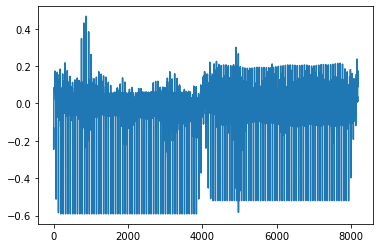

In [35]:
plt.plot(preds_dict['box_preds'].detach().cpu()[:,:,:,:,4
                                               ].view(-1))

In [39]:
box_preds = preds_dict["box_preds"]
cls_preds = preds_dict["cls_preds"]
batch_size_dev = cls_preds.shape[0]
labels = example['labels']
reg_targets = example['reg_targets']
importance = example['importance']

In [44]:
from second.pytorch.models.voxelnet import prepare_loss_weights
cls_weights, reg_weights, cared = prepare_loss_weights(
            labels,
            pos_cls_weight=net._pos_cls_weight,
            neg_cls_weight=net._neg_cls_weight,
            loss_norm_type=net._loss_norm_type,
            dtype=box_preds.dtype)


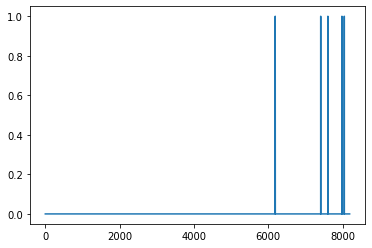

In [53]:
cls_targets = labels * cared.type_as(labels)
plt.plot(cls_targets[0].detach().cpu())

In [54]:
cls_targets = cls_targets.unsqueeze(-1)

In [57]:
net._num_direction_bins

2

In [59]:
net._loc_loss_ftor

In [63]:
box_preds = box_preds.view(1, -1, net._box_coder.code_size)

In [65]:
box_preds.shape

torch.Size([1, 8192, 7])

In [67]:
cls_preds = cls_preds.view(1, -1, 1)

In [70]:
import torchplus
one_hot_targets = torchplus.nn.one_hot(cls_targets, depth=1+1, dtype=box_preds.dtype)

In [81]:
one_hot_targets = one_hot_targets[..., 1:]

In [82]:
one_hot_targets.shape

torch.Size([1, 8192, 1, 1])

In [83]:
net._cls_loss_ftor

In [27]:
coor[:,1] = 0

NameError: name 'coor' is not defined

In [ ]:
coor

In [ ]:
def scatter_nd(indices, updates, shape):
    """pytorch edition of tensorflow scatter_nd.
    this function don't contain except handle code. so use this carefully
    when indice repeats, don't support repeat add which is supported
    in tensorflow.
    """
    ret = torch.zeros(*shape, dtype=updates.dtype, device=updates.device)
    ndim = indices.shape[-1]
    output_shape = list(indices.shape[:-1]) + shape[indices.shape[-1]:]
    flatted_indices = indices.view(-1, ndim)
    slices = [flatted_indices[:, i] for i in range(ndim)]
    slices += [Ellipsis]
    ret[slices] = updates.view(*output_shape)
    return ret

res = scatter_nd(coor.long(), torch.tensor([1]*16405), [1,1,512,  512])

In [ ]:
res

In [ ]:
res0 = scatter_nd(example['coordinates'].long(), torch.tensor([1]*16405), [1,1,512,512])

In [ ]:
example['coordinates'].shape

In [ ]:
coor.shape

In [ ]:
plt.figure(figsize=(6,12))
plt.imshow(res[0][0].detach().cpu().numpy())

In [ ]:
points = example['points']
x = points[:,0]
y = points[:,1]
z = points[:,2]
r = np.sqrt(x**2 + y**2 + z **2)
plt.plot(r)


In [ ]:
plt.plot(np.log(r)/0.008297)

In [ ]:
import second


In [ ]:
feature = second.sphere.transform.xyz2range(example['points'])

In [ ]:
depth = second.sphere.conv.init_depth_from_feature(feature[np.newaxis,:], 70)

In [ ]:
feature.shape

In [ ]:
plt.figure(figsize=(12,12))
plt.imshow(depth[0])